In [16]:
%matplotlib inline
import swat as sw

import dlpy
from dlpy.network import *
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.layers import *

from matplotlib import pylab as plt
from matplotlib import image as mpimg

In [2]:
s = sw.CAS( hostname, portno)

In [3]:
s.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.00264s, user: 0.00176s, sys: 0.000866s, mem: 0.214mb

### Load input images

In [4]:
raw = ImageTable.load_files(conn=s, path='/disk/linux/dlpy/segmentation_data/raw')

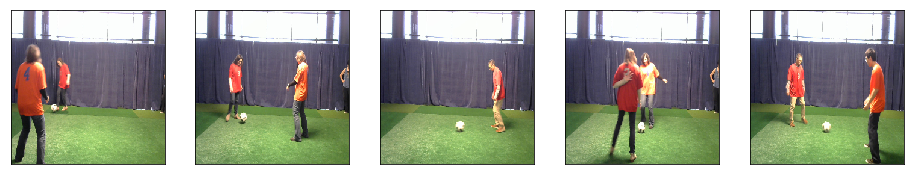

In [5]:
raw.show()

In [6]:
raw.image_summary

jpg                     8
minWidth              256
maxWidth              256
minHeight             256
maxHeight             256
meanWidth             256
meanHeight            256
mean1stChannel      118.9
min1stChannel           0
max1stChannel         255
mean2ndChannel    135.073
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    131.363
min3rdChannel           0
max3rdChannel         255
dtype: object

### Load mask images
Mask images only contain [0, 1, 2] so they appear to be all black
0, 1, 2 are representing each class here, player, ball, and, background

In [7]:
mask = ImageTable.load_files(conn=s, path='/disk/linux/dlpy/segmentation_data/mask')

In [8]:
mask.image_summary

jpg                      8
minWidth               256
maxWidth               256
minHeight              256
maxHeight              256
meanWidth              256
meanHeight             256
mean1stChannel    0.104921
min1stChannel            0
max1stChannel            2
mean2ndChannel    0.104921
min2ndChannel            0
max2ndChannel            2
mean3rdChannel    0.104921
min3rdChannel            0
max3rdChannel            2
dtype: object

In [9]:
# manipulate column names
s.altertable(mask, columns=[dict(name='_image_', rename='labels')])
s.altertable(mask, columns=[dict(name='_label_', drop=True)])
s.altertable(mask, columns=[dict(name='_id_', drop=True)])

+ Elapsed: 0.000127s, mem: 0.295mb

### Use dljoin to combine two tables using _filename_0 as unique id

In [10]:
# this combines two tables (actual image, stored in the raw folder in this case, 
# and the ground truth, stored in the mask folder in this case)
s.dljoin(table=raw, annotatedtable=mask, id='_filename_0', casout=dict(name='data', replace=1))

,casLib,Name,Rows,Columns,casTable
0,CASUSER(ethem-kinginthenorth),data,8,5,"CASTable('data', caslib='CASUSER(ethem-kinginthenorth)')"


In [12]:
s.table.fetch('data', to=2, sasTypes=False)

,_filename_0,_image_,_label_,_id_,labels
0,0307_image10.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,0307_image12.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


### Using the 'create_segmentation_table' API

In [17]:
tbl = create_segmentation_table(s,
                                path_to_images='/disk/linux/dlpy/segmentation_data/raw',
                                path_to_ground_truth='/disk/linux/dlpy/segmentation_data/mask')

NOTE: Images are loaded
NOTE: Ground truth images are loaded
NOTE: Added action set 'deepLearn'.


In [15]:
tbl.fetch(to=2)

,_filename_0,_image_,_label_,_id_,labels
0,0307_image10.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,0307_image12.png,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
